# Generalised von mises fischer (Inputs are vectors) & clustering application

In [5]:
import numpy as np
import pandas as pd
from math import exp, pi, log
from scipy.special import iv
import random
from collections import Counter
import math
import scipy.integrate as integrate
from scipy.optimize import brentq as root
import scipy.special as scp
from matplotlib import pyplot as plt

# Simulated data  (or any dataset can be loaded in to the variable 'main_df' from outside)

>> <b>3 mixtures of 2 features</b>

In [53]:
c = [[x,y] for x,y in zip(list(np.random.normal(100,20,500)) , list(np.random.normal(50,10,500)))]

d = [[x,y] for x,y in zip(list(np.random.normal(50,10,1000)) , list(np.random.normal(0,10,1000)))]

e = [[x,y] for x,y in zip(list(np.random.normal(50,10,750)) , list(np.random.normal(100,20,750)))]

dat_raw = c+d+e

main_df = pd.DataFrame(dat_raw,columns=['feature-1','feature-2'])

In [54]:
main_df

,feature-1,feature-2
0,101.475684,41.766115
1,89.694059,40.626553
2,106.105400,46.188497
3,77.271619,45.878958
4,99.909611,38.437094
5,117.599475,55.006588
6,110.036191,62.348446
7,80.104642,38.034125
8,76.774727,63.755873
9,168.711913,29.008731


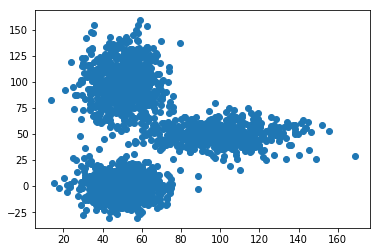

In [55]:
plt.scatter([a[0] for a in dat_raw],[a[1] for a in main_df.values.tolist()])

# Main function of the algorithm

In [56]:
def vm_clust(main_df, num_clusters):
    dat_raw = main_df.values.tolist()
    def unit_vec_fn(ls):
        """Convert the list of raw n-dimensional data into
        a list of set of unit vectors 
        """    
        magnitude  = pow(sum([a**2 for a in ls]),0.5)
        unit_vector  = [c/magnitude for c in ls]
        return(unit_vector)
    ######################################################################
    
    dat_ls = [unit_vec_fn(a) for a in dat_raw]
    p = len(dat_ls[0])
    ######################################################################    
    
    def _get_vmf_likelihood_term(x, mu, kappa):
        """returns the likelihood back to the function 'vmf_pdf2()' that calculates the pdf"""
        return exp(kappa * np.dot(mu, x))
    ######################################################################
    
    def _get_vmf_normalization_numerator(p, kappa): 
        """returns a part of the numerator of the pdf back to the function 'vmf_pdf2()' that calculates the pdf"""
        return kappa ** (0.5*p - 1)
    ######################################################################
    
    def _get_vmf_normalization_denom(p, kappa):
        """returns a part of the denominator of the pdf back to the function 'vmf_pdf2()' that calculates the pdf"""
        return (2 * pi) ** (0.5*p) * iv(0.5*p-1, kappa)
    ######################################################################

    def vmf_pdf2(x, mu, kappa):
        """
        Pdf of the von Mises-Fisher distribution for a list of inputs at a time(unit vectors)
        Parameters:
            mu: list, location parameter
            kappa: float/int, scale parameter. Large values of kappa corresponds to lower variance
        Returns:
            list, pdf function
        """
        p=len(dat_ls[0])
        likelihood = _get_vmf_likelihood_term(x, mu, kappa)
        normalization_numerator = _get_vmf_normalization_numerator(p, kappa)
        normalization_denominator = _get_vmf_normalization_denom(p, kappa)
        return likelihood * (normalization_numerator / normalization_denominator)
    ######################################################################

    def vmf_pdf(x, mu, kappa, log = False):
        """
        Pdf of the von Mises-Fisher distribution for one input
        Parameters:
            mu: list, location parameter
            kappa: float/int, scale parameter. Large values of kappa corresponds to lower variance
        Returns:
            list, pdf function
        """
        if (type(x) == int):
            x = [x]
        if (type(x) == float):
            x = [x]
        vm = np.zeros(len(x))
        if (log):
            if (kappa == 0):
                vm = np.log(np.repreat(1/(2*pi), len(x)))
            elif (kappa < 100000):
                vm = -(np.log(2*math.pi)+np.log(scp.ive(0, kappa)) + kappa) + kappa*(np.cos(np.subtract(x - mu)))
            else:
                if (((x-mu)%(2*math.pi))==0):
                    vm = math.inf
                else:
                    vm = -math.inf
        else:
            if (kappa == 0):
                vm = np.repeat(1/(2*np.pi), len(x))
            elif (kappa < 100000):
                vm = 1/(2 * np.pi * scp.ive(0, kappa)) * (np.exp(np.subtract(np.cos(np.subtract(x, mu)), 1)))**kappa
            else:
                if (np.mod(np.subtract(x, mu),(2*np.pi))==0):
                    vm = math.inf
                else:
                    vm = 0
        return(vm)
    ######################################################################    
    
    def comp_fn(mu,p_i,x,k,kappa):
        """Numerator of the Expectation step in the algorithm and thiis function
        returns to the call from 'Ez_fun()' """
        return p_i[k]*vmf_pdf2(x,mu[k],kappa[k])
    
    ######################################################################  
    
    def Ez_fun(mu,p_i,x,k,kappa):
        """Performs the Expectation step in the EM algorithm"""
        return comp_fn(mu,p_i,x,k,kappa)/sum(list(map(lambda k:comp_fn(mu,p_i,x,k,kappa) ,list(range(0,knum)) )))
    ######################################################################  
    
    knum = num_clusters
    n = len(dat_ls)
    mu = []
    kappa = list(np.repeat(1,num_clusters))
    p_i = list(np.squeeze(np.random.dirichlet(np.ones(num_clusters),size=1)))
    for i in range(0,num_clusters):
        mu.append(list(np.random.uniform(0,1,size = p)))
    ######################################################################  
    
    mu_list=[]
    pi_list=[]
    kappa_list=[]
    Ez_vals = np.full([n,knum], np.nan) 
    itrn = 0
    for iter in range(1,500):
        
      # Expectation (E-step)
    
        for k in range(0,knum):
            """Performs the Expectation step in the EM algorithm for each data set of points"""
            Ez_vals[:,k] = list(map(lambda x:Ez_fun(mu,p_i,x,k,kappa) ,dat_ls )) #P(pi of which fn dat came from/parameters)
  
      # Maximization Step (M-step)
    
        for k in range(0,knum):
            """Performs the Maximization step in the EM algorithm for each data set of points"""
            
            # alpha update
            nk = sum(Ez_vals[:,k]) 
            p_i[k] = nk/n
            
            # mean update
            sum_norm = np.linalg.norm(sum(map(lambda x,y:np.dot(x,y),Ez_vals[:,k],dat_ls)))
            mu[k]= sum(map(lambda x,y:np.dot(x,y),Ez_vals[:,k],dat_ls))/sum_norm 
            
            # kappa update
            R = sum_norm / nk
            mle_kappa = (R * (p - R**2)) / (1 - R**2)
            kappa[k] = mle_kappa  
            
        mu_copy = []
        mu_copy = mu.copy()
        mu_list.append(mu_copy)

        pi_copy = []
        pi_copy = p_i.copy()
        pi_list.append(pi_copy)

        kappa_copy = []
        kappa_copy = kappa.copy()
        kappa_list.append(kappa_copy)

        
        """Convergence/Termination Condition"""
        if(iter!=1):
            summ = 0
            for i in range(0,knum):
                summ = summ + sum([abs(a-b) for a,b in zip(np.squeeze(mu_list).tolist()[-1][i],np.squeeze(mu_list).tolist()[-1][i])]) +abs(pi_list[-1][i]-pi_list[-2][i]) +abs(kappa_list[-1][i]-kappa_list[-2][i])
            if(summ < 0.00001):
                itrn = iter
                break    
    ###################################################################### 
    
    """Clustering"""
    
    list_pdf = []
    for i in range(0,num_clusters):
        list_pdf.append(list(np.squeeze([vmf_pdf(y,np.arctan(mu[i][1]/mu[0][0]),kappa[0]) for y in [float(np.arctan(x[1]/x[0])) for x in dat_ls]])))
    
    df1 = pd.DataFrame(list_pdf).T
    df1.columns=['cluster-'+str(x) for x in range(0,num_clusters)]
    df1['cluster'] = df1.idxmax(1)
    df1['max-pdf'] = df1.max(axis=1)
    df1["total_pdf"] = df1.sum(axis=1) - df1['max-pdf'] 
    df1['%confidence'] = df1['max-pdf']*100/df1['total_pdf']
    final_df = main_df.join(df1)
    ######################################################################     
    
    print("mu:",mu)
    print("kappa:",kappa)
    print("p_i:",p_i)
    return(mu,kappa,p_i,dat_ls,final_df,itrn)  
        

In [57]:
# %timeit mu,kappa,p_i,dat_ls,final_df,itrn = vm_clust(main_df,3)

In [58]:
import time
t1 = time.time()
mu,kappa,p_i,dat_ls,final_df,itrn = vm_clust(main_df,3)
t2=time.time()
print("Time of run for the algorithm:",t2-t1)
# did not use benchmarking timeit functions as it took really long

mu: [array([ 0.99967196, -0.02561188]), array([0.89501589, 0.44603425]), array([0.46165956, 0.88705718])]
kappa: [26.349597558806952, 64.94986598747592, 78.43225236818265]
p_i: [0.4261564128295024, 0.24180337405330343, 0.332040213117195]
Time of run for the algorithm: 35.517996311187744


In [59]:
#Theeta is the actual output for the mixture VMF algorithm in R which is also created here also for comparison

Theeta = [a*kappa[0] for a in np.squeeze(mu).tolist()[0]],[a*kappa[1] for a in np.squeeze(mu).tolist()[1]],[a*kappa[2] for a in np.squeeze(mu).tolist()[2]]
Theeta

([26.340953891548324, -0.6748626485518048],
 [58.131162285989085, 28.969864740296643],
 [36.2089994111327, 69.57389289949847])

# Quality check of the algorithm

In [65]:
# actual clusters are the original clusters that the data was simulated from

actual_clusters = list(np.repeat('cluster-1',1000)) + list(np.repeat('cluster-0',500))+list(np.repeat('cluster-2',750))
final_df['true'] = actual_clusters

In [77]:
# Misclassified classes for difference confidence %

misclass_ls = []
for i in range(0,100,10):
    misclass_ls.append([i,len(final_df[(final_df['cluster']!=final_df['true']) & (final_df['%confidence']>i)])])

In [78]:
# # Correctly classified classes for difference confidence %

correct_ls = []
for i in range(0,100,10):
    correct_ls.append([i,len(final_df[(final_df['true']==final_df['cluster'])&(final_df['%confidence']>i)])])

In [79]:
final_df

,feature-1,feature-2,cluster-0,cluster-1,cluster-2,cluster,max-pdf,total_pdf,%confidence,true
0,101.475684,41.766115,2.152224e-01,2.015171,0.469711,cluster-1,2.015171,2.700104,74.633078,cluster-1
1,89.694059,40.626553,1.463531e-01,2.037112,0.625843,cluster-1,2.037112,2.809307,72.512951,cluster-1
2,106.105400,46.188497,1.728821e-01,2.035738,0.556394,cluster-1,2.035738,2.765014,73.624859,cluster-1
3,77.271619,45.878958,3.569825e-02,1.706558,1.268542,cluster-1,1.706558,3.010799,56.681246,cluster-1
4,99.909611,38.437094,2.737328e-01,1.965547,0.381591,cluster-1,1.965547,2.620871,74.995961,cluster-1
5,117.599475,55.006588,1.269807e-01,2.029435,0.687084,cluster-1,2.029435,2.843500,71.371043,cluster-1
6,110.036191,62.348446,4.723383e-02,1.805850,1.140645,cluster-1,1.805850,2.993730,60.321091,cluster-1
7,80.104642,38.034125,1.185856e-01,2.023042,0.717169,cluster-1,2.023042,2.858797,70.765521,cluster-1
8,76.774727,63.755873,3.014911e-03,0.766175,2.009352,cluster-2,2.009352,2.778542,72.316773,cluster-1
9,168.711913,29.008731,1.231212e+00,0.901892,0.038770,cluster-0,1.231212,2.171874,56.688931,cluster-1


In [94]:
print("Accuracy in Percentage = %s "%(len(final_df[final_df['true']==final_df['cluster']])/len(final_df)*100))

Accuracy in Percentage = 73.28888888888889 


In [95]:
print("Total Number of data points: %s"%(len(final_df)))

Total Number of data points: 2250


In [96]:
final_df2 = pd.DataFrame(misclass_ls,columns=['% confidence of the misclassified','# misclassified'])
final_df2['accuracy %'] = final_df2.apply(lambda x:(len(final_df)-x['# misclassified'])*100/len(final_df),axis=1)
final_df2

,% confidence of the misclassified,# misclassified,accuracy %
0,0,601,73.288889
1,10,601,73.288889
2,20,601,73.288889
3,30,601,73.288889
4,40,601,73.288889
5,50,598,73.422222
6,60,522,76.800000
7,70,427,81.022222
8,80,340,84.888889
9,90,270,88.000000


In [97]:
final_df3 = pd.DataFrame(correct_ls,columns=['% confidence of the correctly-classified','# correctly classified'])
final_df3['accuracy %'] = final_df3.apply(lambda x:(x['# correctly classified'])*100/len(final_df),axis=1)
final_df3

,% confidence of the correctly-classified,# correctly classified,accuracy %
0,0,1649,73.288889
1,10,1649,73.288889
2,20,1649,73.288889
3,30,1649,73.288889
4,40,1649,73.288889
5,50,1633,72.577778
6,60,1517,67.422222
7,70,1336,59.377778
8,80,1067,47.422222
9,90,982,43.644444
